# Figures / analysis for flat slab paper

In [3]:
%pylab inline
import numpy as np

import seaborn as sns
import glob2
import pandas as pd
import h5py
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
import natsort
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
import numpy as np
import pint

u = pint.UnitRegistry()

Populating the interactive namespace from numpy and matplotlib


In [4]:
#ls /workspace2

In [5]:
#dimensionalisation factors

velScale = 3.4482758620689656e-13*(3600*24*365)*100.  #cm/y
timeScale = 8.41e+18/(1e6*3600*24*365)
lengthScale = 2900. #km
stressScale =  11.890606*1e-6   #to MPa

stressScale

1.1890605999999999e-05

## Functions Required

In [6]:
def listify_data(unique_string, path):
    glob_str = path + '*' + unique_string + '*'
    files = natsort.natsort(glob2.glob(glob_str))
    #print(glob_str)
    #return files
    
    dataList = []
    for f in files:
        with h5py.File(f,'r') as hf:
            data = hf.get('data')
            dataList.append(np.array(data))
    return dataList


def get_along_strike(pts):
    dxs = np.diff(pts[:,0])
    dys = np.diff(pts[:,1])
    ds = np.sqrt(dxs**2 + dys**2)
    
    #pad the first point
    return np.append(ds[0], ds) , np.cumsum(np.append([0.], ds)) #front and back pad these arrays


def curvature_splines(x, y):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
    """

    fx = CubicSpline(x, x)
    fy = CubicSpline(x, y)
    #print(np.sqrt(std))

    #x1 = fx.derivative(1)(x)
    #x2 = fx.derivative(2)(x)
    y1 = fy.derivative(1)(x)
    y2 = fy.derivative(2)(x)
    #curvature = (x1* y2 - y1* x2) / np.power(x1** 2 + y1** 2, 1.5)
    curvature = (y2) / np.power(1 + y1** 2, 1.5)

    return curvature, fx, fy, y1

## Setup filter

In [7]:
import scipy.signal as signal
N  = 2    # Filter order
# Cutoff frequency `Wn` is normalized from 0 to 1, 
#where 1 is the Nyquist frequency, pi radians/sample.

#Wn = 0.19 #
#Wn1 = 0.025 #

Wn = 0.26 #
Wn1 = 0.101 #

B, A = signal.butter(N, Wn, output='ba')
B1, A1 = signal.butter(N, Wn1, output='ba')



In [8]:
i = 87               #timestep to analyse


## Dataframe with plate boundary location

In [9]:
def get_dataframe():
    #file_ = '../models/results/A/20/values/tect_model_data.npz'
    file_ = '../models/results/B/16/values/tect_model_data.npz'
    out = np.load(file_)
    d = dict(out)
    df = pd.DataFrame.from_dict(d)
    return df 

df = get_dataframe()

In [10]:
trenchLoc = (df['(2, 3)'].iloc[i] - 30./lengthScale)*lengthScale
print(trenchLoc)

-510.036509971


## Load data

In [11]:
#loads slab midplane points, all timesteps

mppoints = listify_data('midplane**', '../models/results/{}/{}/**/'.format('B', 16))

In [12]:
depthlimit = 1. - (250/2900.)   #depth cutoff (avoids dealing with overturned slab)

In [13]:
#order the data 

indexes = np.argsort(mppoints[i][:,0])
NP = 4    #only us every Nth point
sortedData = mppoints[i].copy()[indexes]
sortedData = sortedData[sortedData[:,1] > depthlimit] #remove deeper points
sortedData = sortedData[sortedData[:,0] > -0.5] #remove points away from the trench
sortedData = sortedData[::NP,:]
ds, ds_cum = get_along_strike(sortedData)
dsMean = ds.mean()


In [14]:
# Second, apply the filter
print(dsMean*lengthScale)
print((1./Wn)*(dsMean*lengthScale))  #wavelength of filter 1
print((1./Wn1)*(dsMean*lengthScale)) #wavelength of filter 2

2.56337263246
9.85912550945
25.379927054


# Estimate the curvature, curvature gradient

In [15]:
fy = CubicSpline(sortedData[:,0], sortedData[:,1])

y1_ = fy.derivative(1)(sortedData[:,0])
y2_ = fy.derivative(2)(sortedData[:,0])
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)

c_F = signal.filtfilt(B,A, c_)

dxMean = ds.min()*1

cx_0 = np.gradient(c_, dxMean)
cx_F= signal.filtfilt(B,A, cx_0)
cx_F1= signal.filtfilt(B1,A1, cx_0)

## Plot the curvatire gradient, check filters

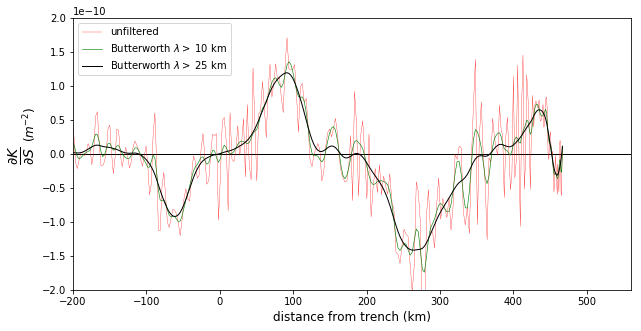

In [16]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(sortedData[::1,0]*2900 - trenchLoc, cx_0*(1./2900e3**2),c = 'r', label='unfiltered', lw = 0.3)
ax.plot(sortedData[::1,0]*2900 - trenchLoc, cx_F*(1./2900e3**2), 
        c = 'g', lw = 0.6, label=r'Butterworth $\lambda >$ 10 km')
ax.plot(sortedData[::1,0]*2900 - trenchLoc, cx_F1*(1./2900e3**2), 
        c = 'k', lw = 1, label=r'Butterworth $\lambda >$ 25 km')


ax.set_xlabel('distance from trench (km)', size = 12)
ax.set_ylabel(r'$\frac{\partial{K}}{\partial{S}}$ ', size = 20)


ax.hlines(0, -200, 600, lw=1)
#ax.plot(sortedData[::n,0], cxF)
ax.set_ylim(-2e-10, 2e-10)
ax.set_xlim(-200, 560)
ax.legend(loc = 2)

ax.text(-270, 0.5e-10, r'($m^{-2}$)', size = 12, rotation=90)

In [17]:
#f.savefig('filtering.png', dpi=400, bbox_inches='tight')

## Save midplane gradient data

In [18]:
midPlaneCurv = np.column_stack( ( 2900.*sortedData[:,0], c_F *(1./2900)  ))
midPlaneCurvGrad = np.column_stack( ( 2900.*sortedData[:,0], cx_F1*(1./2900**2) ))
dimData = np.column_stack(( sortedData[:,0]*2900.0, (1. - sortedData[:,1])*2900.0 ))

#np.savetxt('midPlane.csv', dimData, delimiter=',')
#np.savetxt('curv.csv', midPlaneCurv , delimiter=',')
#np.savetxt('curvGrad.csv', midPlaneCurvGrad, delimiter=',')


## Load the subduction interface data


In [19]:
## Get / save interface 

interfaceOffsetKm = 7.
ifpoints = listify_data('interface**', '../models/results/{}/{}/**/'.format('B', 16))

indexes = np.argsort(ifpoints[i][:,0])
intData = ifpoints[i].copy()[indexes]


#dimIntData0 = np.column_stack((2900.*intData[:,0], 
#                            2900.*(1. - intData[:,1]) - 0. ))
#dimIntData = np.column_stack((2900.*intData[:,0], 
#                           2900.*(1. - intData[:,1]) - interfaceOffsetKm))





#save dimensional interface data
#np.savetxt('slabTop.csv', dimIntData, delimiter=',')


## Set UW mesh, and load fields

In [20]:
import os

import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer


In [21]:
yres = 192
xres = int(yres  * 6)
elementType = 'Q1/dQ0'



mesh = uw.mesh.FeMesh_Cartesian(elementType = (elementType),
                                 elementRes  = (xres, yres)) 

meshFile = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/mesh**.h5'))

mesh.load(meshFile[0])
#Note that when you read in a deformed mesh file, the extents are not correct


scalarField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
tempField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
strainField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )


In [22]:
#sigFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/A/6/sigSS**.h5'))
sigFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/sigSS**.h5'))
sfile = sigFiles[i]

#tempFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/A/6/temp**.h5'))
tempFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/temp**.h5'))
tfile = tempFiles[i]

#strain rate 
#eFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/eSS**.h5'))
#efile = eFiles[i]
#efile

In [23]:
scalarField.load(sfile)
tempField.load(tfile)
#strainField.load(efile)

In [24]:
#fig = glucifer.Figure(figsize=(960,300) )
#fig.append( glucifer.objects.Surface(mesh, tempField,  onMesh=True))
#fig.append( glucifer.objects.Mesh(mesh))

#fig.show()

## Do slab top properly

In [25]:

import sys

#this does't actually need to be protected. More a reminder it's an interim measure
sys.path.append('../../UWsubduction/')
import UWsubduction as usub

#mesh=None
velocityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2)
slabTopI2d = usub.interface2D(mesh, velocityField, intData[:,0], intData[:,1], 1.0, 1.0)

In [26]:
dslength = 7./2900
slabTopRef = slabTopI2d.swarm.particleCoordinates.data[:]
slabTopCorrect = slabTopI2d.swarm.particleCoordinates.data[:] - slabTopI2d.director.data[:]*dslength


dimIntData0 = np.column_stack((2900.*slabTopRef[:,0], 
                            2900.*(1. - slabTopRef[:,1]) - 0. ))
dimIntData = np.column_stack((2900.*slabTopCorrect[:,0], 
                           2900.*(1. - slabTopCorrect[:,1])))





#save dimensional interface data
#np.savetxt('slabTop.csv', dimIntData, delimiter=',')
#np.savetxt('slabTop2.csv', _dimIntData, delimiter=',')
#np.savetxt('slabTop2.csv', _dimIntData, delimiter=',')

In [27]:


dimIntData0 = np.column_stack((2900.*slabTopRef[:,0], 
                            2900.*(1. - slabTopRef[:,1]) - 0. ))
dimIntData = np.column_stack((2900.*slabTopCorrect[:,0], 
                           2900.*(1. - slabTopCorrect[:,1])))


np.savetxt('slabTop.csv', slabTopCorrect, delimiter=',')

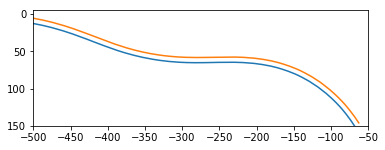

In [28]:
fig, ax = plt.subplots()

ax.plot(dimIntData0[:,0], dimIntData0[:,1])
ax.plot(dimIntData[:,0], dimIntData[:,1])

ax.set_ylim(150, -5)
ax.set_xlim(-500, -50)
ax.set_aspect('equal')

## Setup uniform Numpy grid to interpolate data 

In [50]:
#
dm = 2/2900.               #grid spacing numoy
inset = 0.99999     #build teh grid just inside the undeworld domain to avoid out of bounds errors
inset_ = 1/inset

minx = -2500./2900.
maxx = 2500.0/2900.
maxy = 2900./2900.
miny = 1. - (1250./2900.)

numx = int((inset*maxx - inset*minx)/dm)
meshxs  = np.linspace(inset*minx, inset*maxx, num=numx, endpoint=True)

numy = int((inset*maxy - inset*miny)/dm)
meshys  = np.linspace((1./inset)*miny, inset*maxy, num=numy, endpoint=True)

xv, yv = np.meshgrid(meshxs, meshys )
#uw just wants an Mx2 array
coords = np.array(zip(xv.flatten(), yv.flatten()))

In [51]:
#meshys.min(), mesh.minCoord[1]
#maxy
#coords
meshys.shape, #coords
meshxs.shape

(2499,)

In [52]:
#(mesh.maxCoord[1] - meshys.max())*2900.

print(meshxs.min()*2900, meshxs.max()*2900)
print( (1. - meshys.max())*2900, (1. - meshys.min())*2900 )


(-2499.9749999999999, 2499.9749999999999)
(0.02899999999986802, 1249.9834998349984)


In [53]:
#interpolate data into our numpy arrays
#these are 1-D

stressdata = scalarField.evaluate(coords[:, :])[:,0] 
tempdata = tempField.evaluate(coords[:, :])[:,0]
#straindata = strainField.evaluate(coords[:, :])[:,0]

In [54]:
#Now create teh 2D arrays and dimensionalaze
stress = np.zeros(xv.shape) 
stress[:] = np.flipud(stressdata.reshape((xv.shape)))*stressScale

temp = np.zeros(xv.shape) 
temp[:] = np.flipud(tempdata.reshape((xv.shape)))*1400.0
stress[temp > 1270] = np.nan


#strain = np.zeros(xv.shape) 
#strain[:] = np.flipud(straindata.reshape((xv.shape)))
#strain = np.clip(strain, -5000, 5000)
#strain[temp > 1270] = np.nan

In [55]:
#save the numpy arrays

#np.savetxt('temp.csv', temp, fmt='%.2f', delimiter=',')
#np.savetxt('stress.csv', stress, fmt='%.2f', delimiter=',')
#np.savetxt('xcoords.csv', xv, fmt='%.2f', delimiter=',')
#np.savetxt('ycoords.csv', yv, fmt='%.2f', delimiter=',')


#testtemp = np.loadtxt('temp.csv', delimiter=',')
#testy = 
#plt.imshow(testtemp)

In [56]:
#plt.imshow(stress)

## Plot temperature

In [57]:
trenchLoc


-510.03650997091023

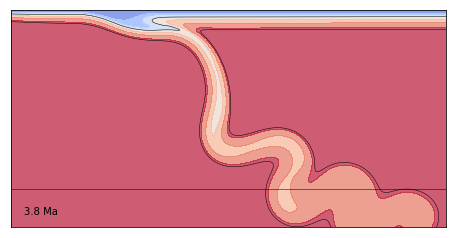

In [58]:
fig, ax = plt.subplots(figsize=(12, 4))
#ax.imshow(stress, cmap='coolwarm', vmax = 150, vmin = -150, 
#          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 1000, 0] )
times = [3.8, 7.7, 12.5, 17.3, 22.2, 30.1]
lf = ax.contourf(temp, cmap='coolwarm', vmax = 1300, vmin = 1, 
          extent=[meshxs.min()*2900, meshxs.max()*2900, (1. - meshys.max())*2900, (1. - meshys.min())*2900], 
                alpha = 0.65,
                levels = [    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1420.])

ax.contour(temp, colors='k', levels=[ 600., 1250.], 
                 extent=[meshxs.min()*2900, meshxs.max()*2900, (1. - meshys.max())*2900, (1. - meshys.min())*2900], 
           linewidths = 0.5 )

ax.hlines(660, -1000, 1000,  alpha = 0.5 , linewidths = 1 )

ax.set_xlim(-800, 800)
ax.set_ylim(800, 0)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

ax.text(-750, 750,'{} Ma'.format(times[0]), size = 10)


In [59]:
#f.savefig('evolution.png', dpi=300, bbox_inches='tight')

## Plot resolved stress, curvature etc.

In [35]:
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

In [36]:
#tressLevels = np.linspace(-90, 90, 7, endpoint=True)
stressLevels = [-100,-60., -30., -10.,  10.,  30.,  60., 100]

NameError: name 'stress' is not defined

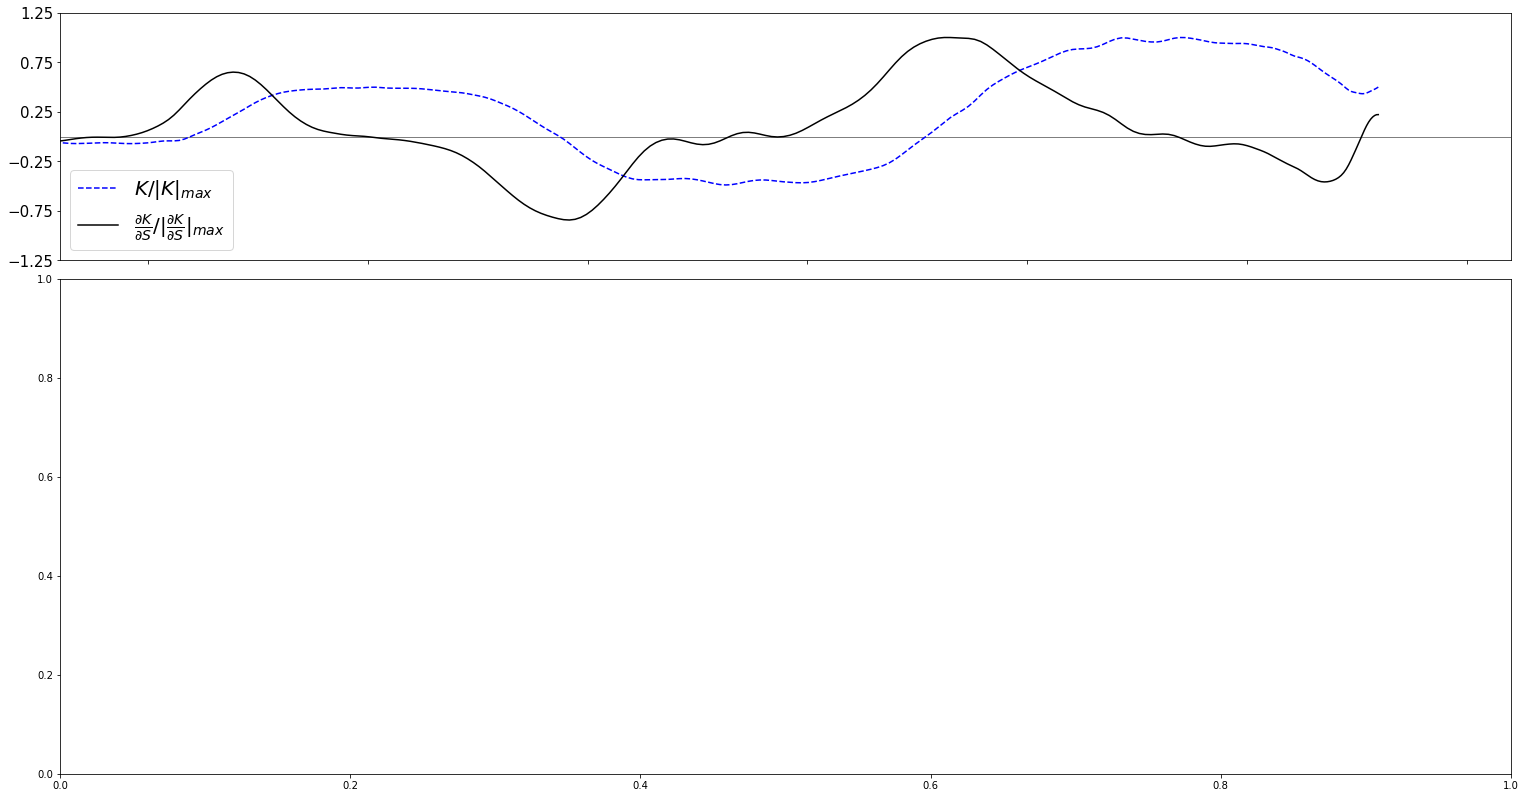

In [343]:
# plot it


fig = plt.figure(figsize=(26, 14)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2]) 
gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

########################


indexWedge = np.argmin(np.abs(dimIntData[:,1] - 45)) #this determines where the LVW intersects the subduction interface

ax0 = plt.subplot(gs[0])

#ax0.plot(2900.*sortedData[:-10],(y2/abs(y2.max()))[:-10] , c= 'k', ls = '--', 
#         label = r'$\frac{K_{,s}}{K_{,s_{max}}}$', lw = 2)

blok = -10
blok1 = 50
blok2 = -50

ax0.plot( 2900.*sortedData[::1,0][:blok ] - trenchLoc, -1.*c_F[:blok ]/np.abs(c_F[blok1:blok2]).max() , 
         c = 'b',ls = '--', label = r'$K/\left|K\right|_{max}$' )

ax0.plot( 2900.*sortedData[::1,0][:blok ] - trenchLoc, -1.*cx_F1[:blok ]/np.abs(cx_F1[blok1:blok2]).max() ,  
         c = 'k', label = r'$ \frac{ \partial{K}  }{ \partial{S}} / \left|\frac{ \partial{K}  }{ \partial{S}}\right|_{max} $' )




ax0.hlines(0 , -650. -  trenchLoc, 10. - trenchLoc, linewidths = 0.5)
ax0.set_xlim(-650. - trenchLoc, 10. - trenchLoc)
ax0.set_ylim(-1.1, 1.1)
ax0.set_yticks(ax0.get_yticks()[::2])

ax0.tick_params(labelsize=15)



#ax0.ticklabel_format(style='sci',axis='y', scilimits=(0,0))

ax0.legend(fontsize = 20)

#ax0.set_yticklabels([])
ax0.set_xticklabels([])
#ax0.grid(False)

########################
ax1 = plt.subplot(gs[1])



cb = ax1.contourf(-1.*stress, cmap='bwr_r', vmax = 100, vmin = -100, 
                  levels = stressLevels,
                  extent=[meshxs.min()*2900 - trenchLoc, meshxs.max()*2900 - trenchLoc, (1. - meshys.max())*2900, (1. - meshys.min())*2900], 
                  linewidths = 1. )



CS = ax1.contour(temp, colors='k', levels=[600, 1250.], 
                  extent=[meshxs.min()*2900 - trenchLoc, meshxs.max()*2900 - trenchLoc, (1. - meshys.max())*2900, (1. - meshys.min())*2900], 
                linewidths = 3.5 )


cl = ax1.clabel(CS, fontsize=15, inline=1, fmt='%1.0f' + ' C', 
           manual=[(500,70),(450, 30)], inline_spacing=-15)

#this one is used for extracting the temperature contours. (trench offset not applied)
#CS2 = ax1.contour(temp, colors='k', levels=[700., 1250.], 
#                 extent=[mesh.minCoord[0]*2900 , mesh.maxCoord[0]*2900 , 0, 1250] )


ax1.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], c= 'k', ls = '--', lw = 2)


#mask = dimData0[:,1] < 90.
mask = dimIntData0[:,1] <78.

ax1.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '--', lw= 2)
#ax1.plot(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1], c = 'k', lw= 2)

ax1.fill_between(dimIntData0[mask,0] - trenchLoc, dimIntData0[mask,1] - 1. , 
                 dimIntData[mask,1], facecolor='green', alpha=0.75)

ax1.fill_between(dimIntData[indexWedge:,0] - trenchLoc, 
                 dimIntData[indexWedge:,1], 45*np.ones(len(dimIntData[indexWedge:,1])), facecolor='gray', alpha=0.85) 


#ax1.hlines(75, -650 - trenchLoc, 10 - trenchLoc)
ax1.set_xlim(-650 - trenchLoc, 10 - trenchLoc)
ax1.set_ylim(200, -0.5)

ax1.set_ylabel('depth (km)', size = 15)
ax1.set_xlabel('distance from trench (km)', size = 15)
ax1.grid(False)
ax1.tick_params(labelsize=15)


# Now adding the colorbar
cbaxes = fig.add_axes([0.14, 0.18, 0.4, 0.05]) 
cb1 = colorbar(cb, cax = cbaxes, orientation="horizontal") 
cb1.set_label(r'$\sigma_{ss} =  (\sigma_{ij} \cdot \hat s)\cdot \hat s$ (MPa)', size= 20, labelpad=-100)
cb1.set_ticks(stressLevels[:])
#cb1.ax.set_xticklabels(stressLevels[::2]) 


ax1.plot([290,305], [56,71], lw = 7, c='k')
ax1.set_aspect('equal')

In [109]:
#fig.savefig('stress_curv_2.png', dpi=250, bbox_inches='tight')

## Different way of plotting

In [38]:
hf = h5py.File('./analysis_data/mesh.h5', 'r')
meshData = np.array(hf.get("vertices"))

hf = h5py.File('./analysis_data/temp_2200.h5', 'r')
tempData = np.array(hf.get("data"))

hf = h5py.File('./analysis_data/sigSS_2200.h5', 'r')
stressData = np.array(hf.get("data"))

hf = h5py.File('./analysis_data/midplane02200.h5', 'r')
midplaneData = np.array(hf.get("data"))

hf = h5py.File('./analysis_data/interface02200.h5', 'r')
interfaceData = np.array(hf.get("data"))

hf = h5py.File('./analysis_data/sigII2_2202.h5', 'r')
stressInvData = np.array(hf.get("data"))

hf = h5py.File('./analysis_data/eSS_2202.h5', 'r')
strainData = np.array(hf.get("data"))

In [103]:
hf = h5py.File('./analysis_data/eig_2202.h5', 'r')
eigData = np.array(hf.get("data"))

In [79]:
stressData[tempData*1400.  > 1270] = 0.0

In [31]:
#tempLevels = [200, 400., 600, 1000, 1250, 1405 ]
tempLevels = [    0.,   200.,   400.,   600.,   800.,  1000.,  1250.,  1400.]

In [32]:
dfEQ = pd.read_csv('./analysis_data/pps.csv')



dfEQW = dfEQ[dfEQ.sector == 'western'].copy()
dfEQW['mNorm'] = (dfEQW.m - dfEQW.m.min())/(dfEQW.m.max()- dfEQW.m.min())
dfEQE = dfEQ[dfEQ.sector == 'eastern']



In [33]:
dfEQ.head(3)

,id,distance,adj.depth,depth,m,temp,adj.temp,stress,adj.stress,sector
0,1,102.327159,-35.000000,-35.0,5.5,224.12,224.12,-0.15,-0.15,eastern
1,2,104.339079,-35.000000,-35.0,5.5,219.20,219.20,0.08,0.08,eastern
2,3,247.412883,-84.265221,-79.0,5.0,673.72,805.78,95.78,-80.86,western


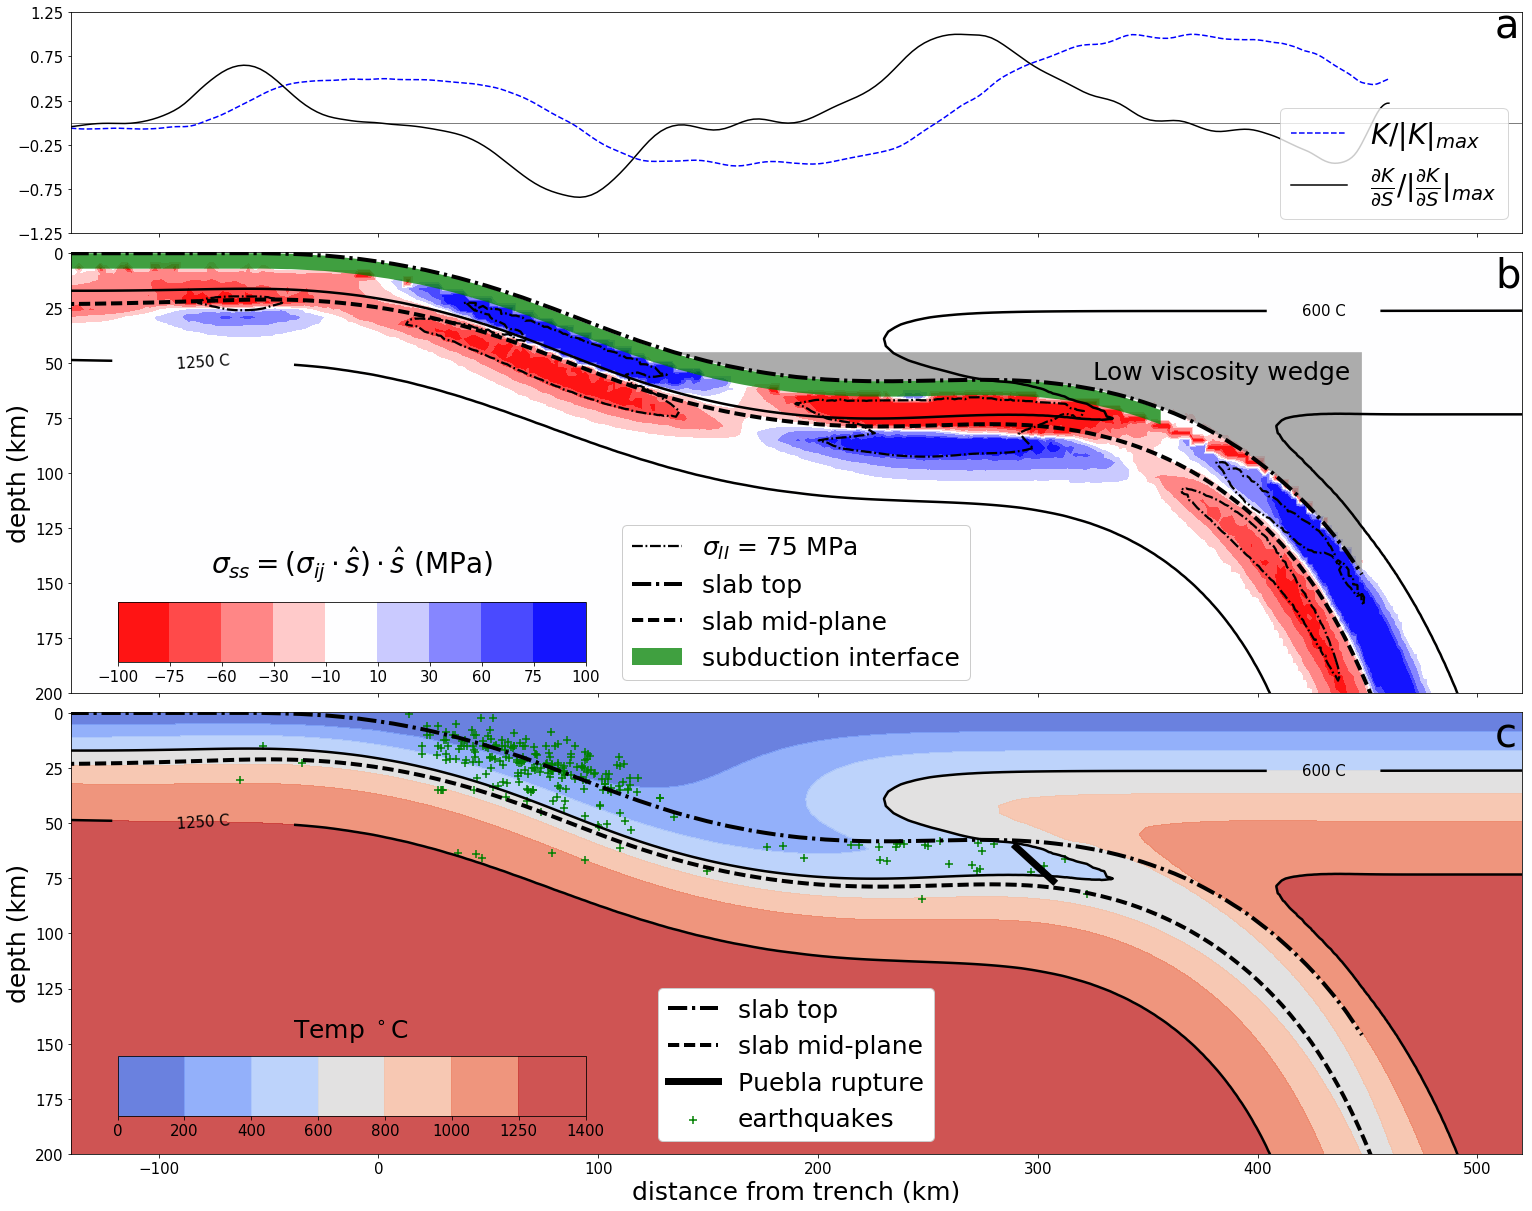

In [316]:
# plot it

tempLevels = [    0.,   200.,   400.,   600.,   800.,  1000.,  1250.,  1400.]
stressLevels = [-100.,  -75.,  -60.,  -30.,  -10, 10,  30.,   60.,   75.,  100.]


fig = plt.figure(figsize=(26, 21)) 
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 2, 2]) 
gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

########################


indexWedge = np.argmin(np.abs(dimIntData[:,1] - 45)) #this determines where the LVW intersects the subduction interface

ax0 = plt.subplot(gs[0])

#ax0.plot(2900.*sortedData[:-10],(y2/abs(y2.max()))[:-10] , c= 'k', ls = '--', 
#         label = r'$\frac{K_{,s}}{K_{,s_{max}}}$', lw = 2)

blok = -10
blok1 = 50
blok2 = -50

ax0.plot( 2900.*sortedData[::1,0][:blok ] - trenchLoc, -1.*c_F[:blok ]/np.abs(c_F[blok1:blok2]).max() , 
         c = 'b',ls = '--', label = r'$K/\left|K\right|_{max}$' )

ax0.plot( 2900.*sortedData[::1,0][:blok ] - trenchLoc, -1.*cx_F1[:blok ]/np.abs(cx_F1[blok1:blok2]).max() ,  
         c = 'k', label = r'$ \frac{ \partial{K}  }{ \partial{S}} / \left|\frac{ \partial{K}  }{ \partial{S}}\right|_{max} $' )


ax0.hlines(0 , -650. -  trenchLoc, 10. - trenchLoc, linewidths = 0.5)
ax0.set_xlim(-650. - trenchLoc, 10. - trenchLoc)
ax0.set_ylim(-1.1, 1.1)
ax0.set_yticks(ax0.get_yticks()[::2])

ax0.tick_params(labelsize=15)



#ax0.ticklabel_format(style='sci',axis='y', scilimits=(0,0))

ax0.legend(loc=4, fontsize = 28)

#ax0.set_yticklabels([])
ax0.set_xticklabels([])
#ax0.grid(False)

########################
ax1 = plt.subplot(gs[1])



tempScale= 1400.0
levels=np.linspace(0., tempScale + 5, 10, endpoint=True)

cb = ax1.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  -1.*stressData[:,0]*stressScale, 
                vmax = 95, vmin = -95,
                levels = stressLevels, cmap='bwr_r')

#cb = ax1.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
#                -1.*np.sign(strainData[:,0])*stressInvData[:,0]*stressScale, 
#                vmax = 99, vmin = -99,
#                    levels=stressLevels,
#                    cmap='seismic_r', alpha=0.5)


CS = ax1.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.5 )

CS_ = ax1.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               stressScale*stressInvData[:,0],  levels = [75], colors= 'k', linewidths = 2.25, linestyles='-.' )
ax1.plot([-1000, -1001],[1000, 1001], label = r'$\sigma_{II}$ = 75 MPa',c= 'k', lw = 2.25, ls='-.'   )



#cl_ = ax1.clabel(CS_, fontsize=10, inline=1, fmt='%1.0f' + r'$\sigma_{II}$ MPa', 
#           manual=[(50,70),], inline_spacing=1)


cl = ax1.clabel(CS, fontsize=15, inline=1, fmt='%1.0f' + ' C', 
           manual=[(-80,70),(430, 30)], inline_spacing=-15)


#ax1.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
#         c= 'k', ls = '--', lw = 4, label = 'slab mid-plane')


#mask = dimData0[:,1] < 90.
mask = dimIntData0[:,1] <78.

#ax1.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '--', lw= 2)
#ax1.plot(dimIntData0[:,0] - trenchLoc, dimIntData0[:,1], c = 'k', lw= 2)

ax1.fill_between(dimIntData0[mask,0] - trenchLoc, dimIntData0[mask,1]  , 
                 dimIntData[mask,1], facecolor='green', alpha=0.75, label = 'subduction interface')

ax1.fill_between(dimIntData[indexWedge:,0] - trenchLoc, 
                 dimIntData[indexWedge:,1], 45*np.ones(len(dimIntData[indexWedge:,1])), 
                 facecolor='gray', alpha=0.65) 


#ax1.hlines(75, -650 - trenchLoc, 10 - trenchLoc)
ax1.set_xlim(-650 - trenchLoc, 10 - trenchLoc)
ax1.set_ylim(200, -0.5)

ax1.set_ylabel('depth (km)', size = 25)
ax1.grid(False)
ax1.tick_params(labelsize=15)


ax1.text(325, 57,'Low viscosity wedge', size = 25)


#top of slab
ax1.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 4, label='slab top')

ax1.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 4, label = 'slab mid-plane')

#ax1.text(220, 110, r'$\sigma_{II}$ = 80 MPa', size = 22)


# Now adding the colorbar
#cbaxes = fig.add_axes([0.14, 0.18, 0.4, 0.05]) 
cbaxes = fig.add_axes([0.15, 0.45, 0.25, 0.04]) 

cb1 = colorbar(cb, cax = cbaxes, orientation="horizontal") 
cb1.set_label(r'$\sigma_{ss} =  (\sigma_{ij} \cdot \hat s)\cdot \hat s$ (MPa)', size= 28, labelpad=-140)
#cb1.set_label(r'$\sigma_{II}$ (signed)', size= 28, labelpad=-140)
cb1.set_ticks(stressLevels[:])
cbaxes.tick_params(labelsize=15)

ax1.set_aspect('equal')
ax1.set_xticklabels([])

leg1 = ax1.legend(loc = 8, fontsize = 25)
leg1.get_frame().set_alpha(1.0)

#ax 3

ax2 = plt.subplot(gs[2])

cb2 = ax2.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0],
                      vmax = 1400, vmin = 0.,
                      levels=tempLevels, cmap='coolwarm', alpha=0.85)

CS2 = ax2.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.5 )






c2 = ax2.clabel(CS2, fontsize=15, inline=1, fmt='%1.0f' + ' C', 
           manual=[(-80,70),(430, 30)], inline_spacing=-15)

#these ones for saving the contours in original reference frame
#CS2 = ax2.tricontour((2900*meshData[:,0]), 2900*(1. - meshData[:,1]),  
#               tempScale*tempData[:,0], levels = [650, 1250], colors= 'k', linewidths = 2.5 )




cbaxes2 = fig.add_axes([0.15, 0.15, 0.25, 0.04]) 

cb2 = colorbar(cb2, cax = cbaxes2, orientation="horizontal") 
cb2.set_label(r'Temp $^\circ$C ', size= 25, labelpad=-120)
cbaxes2.tick_params(labelsize=15)

#cb2.set_ticks(stressLevels[:])

#top of slab
ax2.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 4, label='slab top')

ax2.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 4, label = 'slab mid-plane')


#290 -60.76315
#313 -76.26315
#puebla approx
#ax2.plot([290,305], [56,71], lw = 7, c='k')
ax2.plot([290,307], [60.7,76.2], lw = 7, c='k', label='Puebla rupture')


ax2.scatter(dfEQ.distance, -1.*dfEQ['adj.depth'], c='g', marker='+', s =80, label = 'earthquakes' )
#ax2.scatter(dfEQ.distance, -1.*dfEQE['adj.depth'], c='g', marker='o', s =60, label = 'eqs. eastern MFS'  )

leg = ax2.legend(loc = 8, fontsize = 25)
leg.get_frame().set_alpha(1.0)


ax2.set_xlim(-650 - trenchLoc, 10 - trenchLoc)
ax2.set_ylim(200, -0.5)
ax2.set_xlabel('distance from trench (km)', size = 25)
ax2.set_ylabel('depth (km)', size = 25)
ax2.grid(False)
ax2.tick_params(labelsize=15)


ax0.text(508, 0.96, 'a', size = 40)
ax1.text(508, 15, 'b', size = 40)
ax2.text(508, 15, 'c', size = 40)



In [280]:
#fig.savefig('stress_curv_3panel.png', dpi=300, bbox_inches='tight')

In [384]:
np.rad2deg(np.arctan((76.2 - 60.7) /(313 -290.)))

33.976544036256861

In [386]:
(76.2 - 60.7) , (313 -290.), 71 - 56

(15.5, 23.0, 15)

## Stress Inv

In [323]:
timeScaleSecs = 8.41e+18

In [355]:
1e-15*timeScaleSecs, 1e-17*timeScaleSecs

(8410.0, 84.10000000000001)

In [361]:
truncStrain = np.abs(strainData.copy())
truncStrain[truncStrain > 1e4] = 1e4
truncStrain[truncStrain < 1e2] = 1e2

In [362]:
#np.abs(strainData[:,0]/timeScaleSecs).max()
np.abs(strainData[:,0]).max()

1449312.6462720498

In [353]:
strainData[:,0].max()

1345421.2668316474

(200, -0.5)

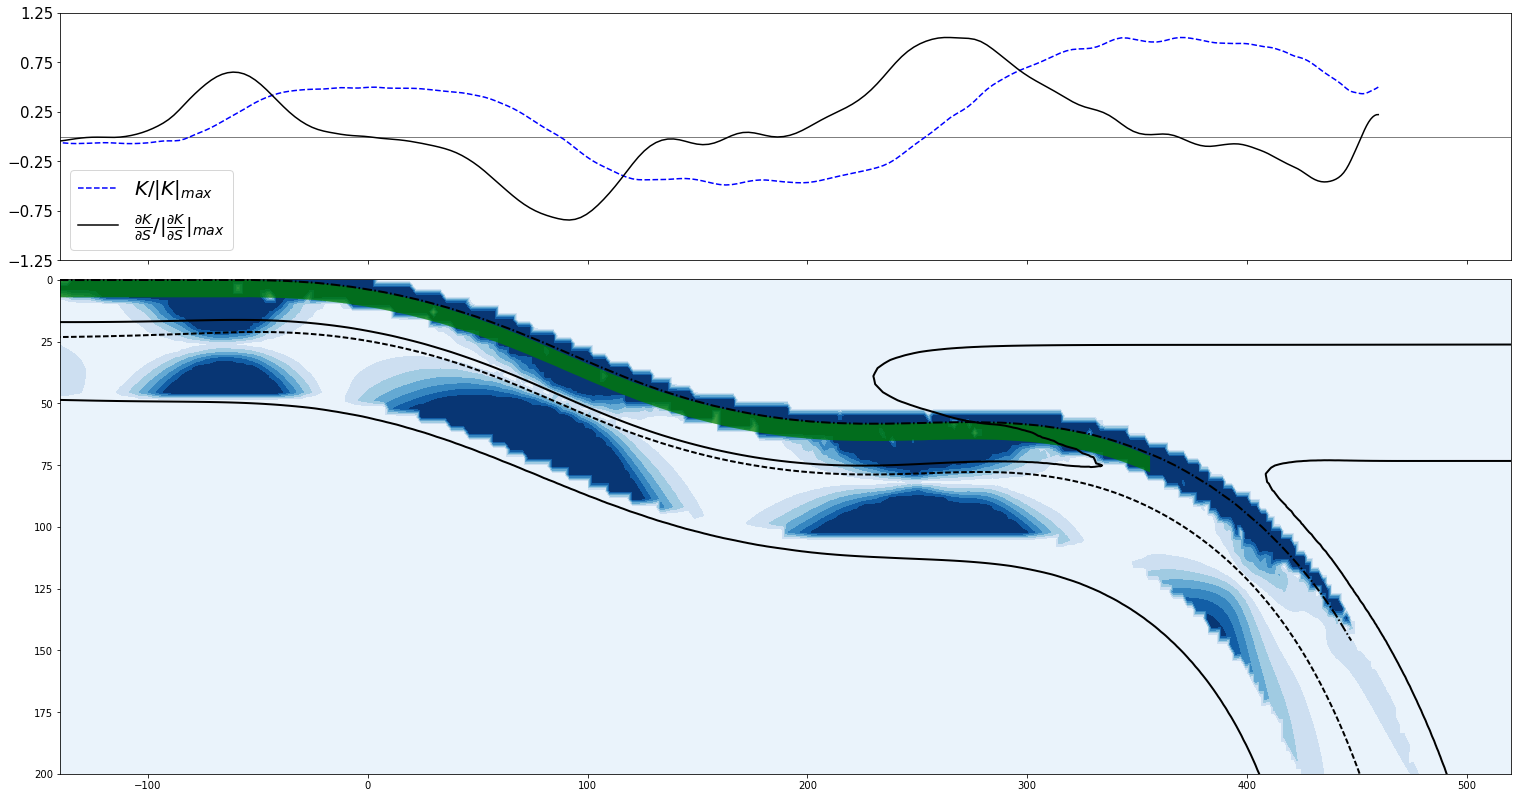

In [367]:
fig = plt.figure(figsize=(26, 14)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2]) 
gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

########################


indexWedge = np.argmin(np.abs(dimIntData[:,1] - 45)) #this determines where the LVW intersects the subduction interface

ax0 = plt.subplot(gs[0])

#ax0.plot(2900.*sortedData[:-10],(y2/abs(y2.max()))[:-10] , c= 'k', ls = '--', 
#         label = r'$\frac{K_{,s}}{K_{,s_{max}}}$', lw = 2)

blok = -10
blok1 = 50
blok2 = -50

ax0.plot( 2900.*sortedData[::1,0][:blok ] - trenchLoc, -1.*c_F[:blok ]/np.abs(c_F[blok1:blok2]).max() , 
         c = 'b',ls = '--', label = r'$K/\left|K\right|_{max}$' )

ax0.plot( 2900.*sortedData[::1,0][:blok ] - trenchLoc, -1.*cx_F1[:blok ]/np.abs(cx_F1[blok1:blok2]).max() ,  
         c = 'k', label = r'$ \frac{ \partial{K}  }{ \partial{S}} / \left|\frac{ \partial{K}  }{ \partial{S}}\right|_{max} $' )




ax0.hlines(0 , -650. -  trenchLoc, 10. - trenchLoc, linewidths = 0.5)
ax0.set_xlim(-650. - trenchLoc, 10. - trenchLoc)
ax0.set_ylim(-1.1, 1.1)
ax0.set_yticks(ax0.get_yticks()[::2])

ax0.tick_params(labelsize=15)



#ax0.ticklabel_format(style='sci',axis='y', scilimits=(0,0))

ax0.legend(fontsize = 20)

#ax0.set_yticklabels([])
ax0.set_xticklabels([])
#ax0.grid(False)

########################
ax1 = plt.subplot(gs[1])

cb = ax1.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                truncStrain[:,0],
                vmin =1e2, vmax = 1e4,
                    cmap='Blues')

#cb = ax.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
#                smoothStressInvData, 
#                vmin =10., vmax = 110,
#                    cmap='bwr_r')

#ax.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 4, label='slab top')

#ax.fill_between(dimIntData0[mask,0] - trenchLoc, dimIntData0[mask,1]  , 
#                 dimIntData[mask,1], facecolor='green', alpha=0.75, label = 'subduction interface')

#CS1 = ax.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
#               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.5 )

#CS2 = ax.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
#               stressScale*stressInvData[:,0],  levels = [50,75], colors= 'k', linewidths = 1. )

#CS3 = ax.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
#               stressScale*,  levels = [75], colors= 'r', linewidths = 1. )

ax1.fill_between(dimIntData0[mask,0] - trenchLoc, dimIntData0[mask,1]  , 
                 dimIntData[mask,1], facecolor='green', alpha=0.75, label = 'subduction interface')

#top of slab
ax1.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 2, label='slab top')

ax1.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 2, label = 'slab mid-plane')


ax1.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.0 )

#ax1.hlines(75, -650 - trenchLoc, 10 - trenchLoc)
ax1.set_xlim(-650 - trenchLoc, 10 - trenchLoc)
ax1.set_ylim(200, -0.5)

In [322]:
smoothStrain.mean()/timeScaleSecs

1.0982424938632901e-17

In [303]:
tempMask = tempScale*tempData[:,0] < 610.

tempMask2 = np.logical_and(tempScale*tempData[:,0] > 610., tempScale*tempData[:,0] < 1250.)

In [304]:
tempMask2.sum()

27299

(150, -0.5)

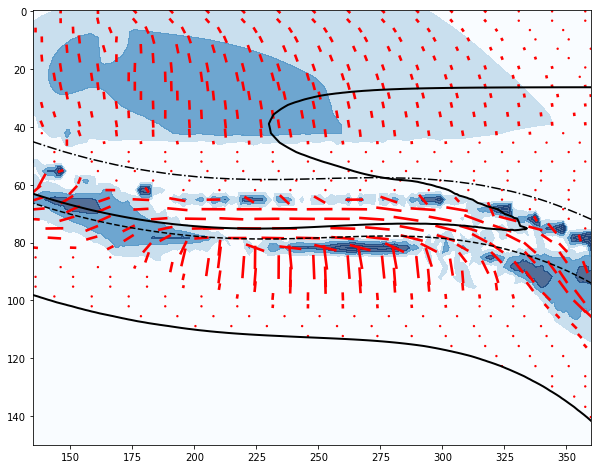

In [314]:
import matplotlib.colors as colors
stressLevels = [-100., -90,  -75.,  -55.,  -25.,  -10, 10,  25.,   55.,   75., 90., 100.]

fig, ax = plt.subplots(figsize=(10, 8))
#ax.imshow(stress, cmap='coolwarm', vmax = 150

#cb = ax.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
#                np.sign(strainData[:,0])*stressInvData[:,0]*stressScale, 
#                vmax = 110, vmin = -110,
#                    cmap='RdYlBu_r')


quiveropts = dict(color='k', headlength=0, pivot='middle', scale=1, 
    linewidth=2, units='xy', width=3, headwidth=1)


#cb = ax.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
#                np.sign(strainData[:,0])*stressInvData[:,0]*stressScale, 
#                vmax = 99, vmin = -99,
#                    levels=stressLevels,
#                    cmap='seismic', alpha=.5)


cb = ax.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                np.abs((np.abs(stressData[:,0]) - stressInvData[:,0] )*stressScale),
                    vmax = 50, vmin = 10,
                    cmap='Blues', alpha=.7)


n = 6
Q1 = plt.quiver((2900*meshData[tempMask,0][::n]) - trenchLoc, 2900*(1. - meshData[tempMask,1][::n]), 
                -1.*stressScale*stressInvData[tempMask,0][::n]*eigData[tempMask,1][::n],
                stressScale*stressInvData[tempMask,0][::n]*eigData[tempMask,0][::n], 
              headlength=0,headaxislength=0,units='xy', width=1., pivot='middle', 
               scale=10., color = 'r')

#Q2 = plt.quiver((2900*meshData[tempMask,0][::n]) - trenchLoc, 2900*(1. - meshData[tempMask,1][::n]), 
#                stressScale*stressInvData[tempMask,0][::n]*eigData[tempMask,1][::n],
#                -1.*stressScale*stressInvData[tempMask,0][::n]*eigData[tempMask,0][::n], 
#              headlength=0,headaxislength=0,units='xy', width=0.75, pivot='middle', 
#               scale=5., color = 'r')

Q2 = plt.quiver((2900*meshData[tempMask2,0][::n]) - trenchLoc, 2900*(1. - meshData[tempMask2,1][::n]),  
                -1.*stressScale*stressInvData[tempMask2,0][::n]*eigData[tempMask2,1][::n],
                stressScale*stressInvData[tempMask2,0][::n]*eigData[tempMask2,0][::n],
              headlength=0,headaxislength=0,units='xy', width=1., pivot='middle',
              scale=10., color = 'r')

ax.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 2.0 )

#top of slab
ax.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 1.5, label='slab top')

#midplane
ax.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 1.5, label = 'slab mid-plane')

#ax1.hlines(75, -650 - trenchLoc, 10 - trenchLoc)
ax.set_xlim(-375 - trenchLoc, -150 - trenchLoc)
ax.set_ylim(150, -0.5)


#cbaxes = fig.add_axes([0.2, 0.2, 0.3, 0.1]) 

#cb1 = colorbar(cb, cax = cbaxes, orientation="horizontal") 
#cb1.set_label(r'$\sigma_{II}\mathrm{sgn}\left((\dot \epsilon_{ij} \cdot \hat s)\cdot \hat s \right)$ (MPa)', 
#              size= 28, labelpad=-100)
#cb1.set_ticks(stressLevels[:])
#cbaxes.tick_params(labelsize=15)

In [266]:
#fig.savefig('stress_eigenvectors', dpi=300, bbox_inches='tight')

(200, -0.5)

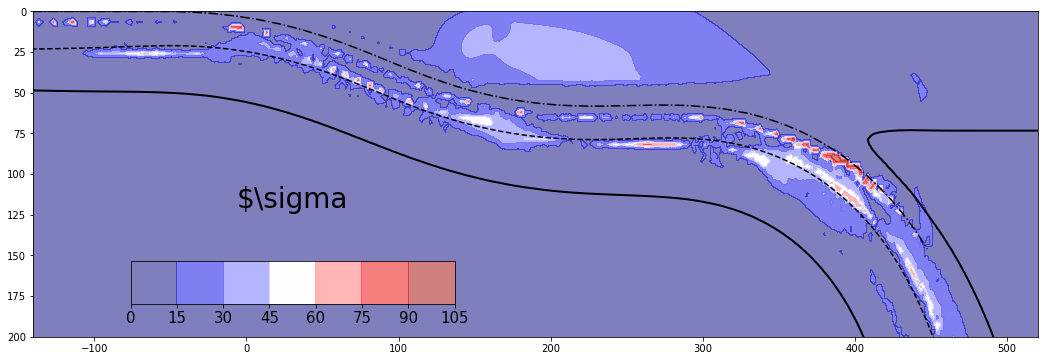

In [290]:
import matplotlib.colors as colors
#stressLevels = [-100., -90,  -75.,  -55.,  -25.,  -10, 10,  25.,   55.,   75., 90., 100.]

fig, ax = plt.subplots(figsize=(18, 6))

cb = ax.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                np.abs((np.abs(stressData[:,0]) - stressInvData[:,0] )*stressScale), 
                    cmap='seismic', alpha=.5)

cbaxes = fig.add_axes([0.2, 0.2, 0.25, 0.1]) 
cb1 = colorbar(cb, cax = cbaxes, orientation="horizontal") 
#cb1.set_label(r'$\sigma_{ss} =  (\sigma_{ij} \cdot \hat s)\cdot \hat s$ (MPa)', size= 28, labelpad=-140)
cb1.set_label(r'$\sigma', size= 28, labelpad=-140)
#cb1.set_ticks(stressLevels[:])
cbaxes.tick_params(labelsize=15)


ax.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
               tempScale*tempData[:,0], levels = [1250], colors= 'k', linewidths = 2.0 )

#top of slab
ax.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1],c= 'k', ls = '-.', lw= 1.5, label='slab top')

#midplane
ax.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], 
         c= 'k', ls = '--', lw = 1.5, label = 'slab mid-plane')

#ax1.hlines(75, -650 - trenchLoc, 10 - trenchLoc)
ax.set_xlim(-650 - trenchLoc, 10 - trenchLoc)
ax.set_ylim(200, -0.5)



## Save contours

In [381]:
p = CS2.collections[0].get_paths()
pv = [path.vertices for path in p]
out = np.concatenate(pv) #already dimensionalized
np.savetxt('650C_contour.csv', out , delimiter=',')

(800, 0)

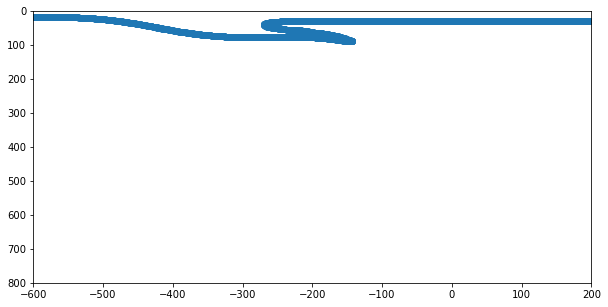

In [382]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(out[:,0] , out[:,1])

ax.set_xlim(-600, 200)
ax.set_ylim(800, 0)
#ax.set_aspect('equal')

## Plot temp at multiple timesteps, fast way

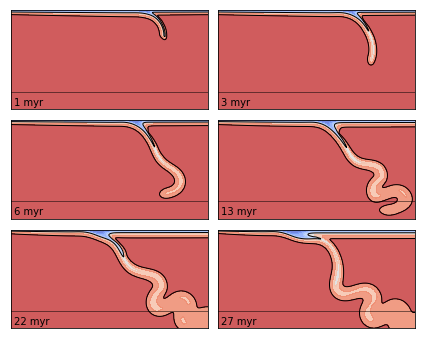

In [448]:
#np.arange(8, 56,8)

times = [1, 3, 6, 13, 22, 27]

tempLevels = [0.0, 200.0, 400.0, 600.0, 800.0, 1000.0, 1250.0, 1410.0]

# Four axes, returned as a 2-d array
#f, axarr = plt.subplots(3, 2)
#f.tight_layout()
f = plt.figure(figsize = (7.25,6))
gs1 = gridspec.GridSpec(3, 2)
gs1.update(wspace=0.05, hspace=0.025)


count = 0
for i in [2, 10, 25, 50, 75, 87]:
    tfile = tempFiles[i]
    #tempField.load(tfile)
    #tempdata = tempField.evaluate(coords[:, :])[:,0]
    #build array to collect the data
    #temp = np.zeros(xv.shape) 
    #temp[:] = np.flipud(tempdata.reshape((xv.shape)))*1400.0
    
    hf = h5py.File(tfile, 'r')
    tempData = np.array(hf.get("data"))
    
    
    ax = plt.subplot(gs1[count])
    #plt.subplot(gs1[i])

    
    cb2 = ax.tricontourf((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                   tempScale*tempData[:,0],
                          vmax = 1400, vmin = 0.,
                          levels=tempLevels, cmap='coolwarm', alpha=0.8)

    ax.tricontour((2900*meshData[:,0]) - trenchLoc, 2900*(1. - meshData[:,1]),  
                   tempScale*tempData[:,0], levels = [600, 1250], colors= 'k', linewidths = 1. )

    ax.hlines(660, -1000, 1200,  alpha = 0.5 , linewidths = 1 )

    ax.set_xlim(-500, 1100)
    ax.set_ylim(800, 0)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    #print(count)
    ax.text(-475, 770,'{} myr'.format(times[count]), size = 10)
    count += 1



In [449]:
#f.savefig('evolution.png', dpi=300, bbox_inches='tight')

## Plot temp at multiple timesteps (can take a while)

In [ ]:
#np.arange(8, 56,8)

times = [19, 27]

# Four axes, returned as a 2-d array
#f, axarr = plt.subplots(3, 2)
#f.tight_layout()
f = plt.figure(figsize = (7.25,6))
gs1 = gridspec.GridSpec(2, 1)
gs1.update(wspace=0.05, hspace=0.025)

count = 0
for i in [67, 87]:
    tfile = tempFiles[i]
    tempField.load(tfile)
    tempdata = tempField.evaluate(coords[:, :])[:,0]
    #build array to collect the data
    temp = np.zeros(xv.shape) 
    temp[:] = np.flipud(tempdata.reshape((xv.shape)))*1400.0
    
    ax = plt.subplot(gs1[count])
    #plt.subplot(gs1[i])

    
    ax.contourf(temp, cmap='coolwarm', vmax = 1400, vmin = 0, 
          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1250], 
                alpha = 0.65, 
               levels = [    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1420.])

    ax.contour(temp, colors='k', levels=[700., 1250.], 
                     extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1250], linewidths = 0.5 )

    ax.hlines(660, -1000, 1000,  alpha = 0.5 , linewidths = 1 )

    ax.set_xlim(-800, 800)
    ax.set_ylim(800, 0)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    #print(count)
    ax.text(-750, 770,'{} Myr'.format(times[count]), size = 10)
    count += 1

## Plate age at trench 

-698.4301633747034

In [15]:
times = np.linspace(0,35., 100)
vp =  np.linspace(9, 3., 100)
vr = 2.
plateLength = abs(df['(1, 2)'][i]*2900 - trenchLoc) - 30. #correction for MOR loc
ageAtFlat = df.timeAtSave.iloc[i]*timeScale

vp_r =  vp - vr #sp velocity on moving trench ref frame

vp *= 10 #factor of 10 converts from cm/y to km/myr
vp_r *= 10 

vgrad = (vp[-1] - vp[0])/times[-1]
int_1 = 0.5*vgrad* times**2 + vp[0]*times
int_2 = 0.5*vgrad* times**2 + vp_r[0]*times

distatT = int_2[np.argmin(np.abs(times - ageAtFlat))]
refDist = distatT - plateLength
ageSlab = ageAtFlat - times[np.argmin(np.abs(int_2 - refDist ))]

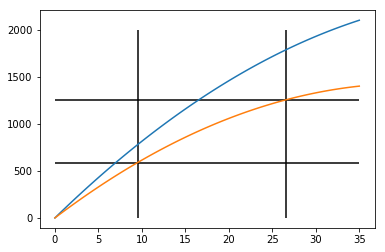

In [16]:
fig, ax = plt.subplots()
ax.plot(times, int_1)
ax.plot(times, int_2)
ax.hlines(refDist ,0, 35 )
ax.hlines(distatT ,0, 35 )

ax.vlines(ageAtFlat, 0, 2000)
ax.vlines(times[np.argmin(np.abs(int_2 - refDist ))], 0, 2000)

In [17]:
print(ageSlab)
print(ageAtFlat)

17.0488469549
26.5943015004


## Convergence velocity

In [18]:
vP = (9 - 3)*(1. - ageAtFlat/35.) + 3.
print(vP  + 2)

6.44097688565


In [24]:
np.sqrt(2)*25

35.355339059327378

## Lithospheric thickness

In [26]:
age = 20.*1e6*365*24*3600.
diff  = 1e-6
potentialTemp = 1400.

ageYoung = 10.*1e6*365*24*3600.
ageOld = 30.*1e6*365*24*3600.

In [27]:
from scipy.special import erfinv

z = (erfinv((650)/potentialTemp))*2.*np.math.sqrt(diff*age)
z

21995.767798749221

In [11]:
zs = np.linspace(0, 80e3, 1000)
TsZRef = [np.math.erf(z/(2.*np.math.sqrt(diff*age)) )*potentialTemp for z in zs]
TsZYoung = [np.math.erf(z/(2.*np.math.sqrt(diff*ageYoung)) )*potentialTemp for z in zs]
TsZOld = [np.math.erf(z/(2.*np.math.sqrt(diff*ageOld)) )*potentialTemp for z in zs]

In [12]:
index700 = np.argmin(np.abs(np.array(TsZRef) - 700.))
d70 = zs[index700]
d70

26186.186186186187

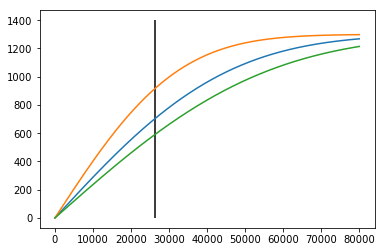

In [13]:
fig, ax = plt.subplots()
ax.plot(zs,TsZRef )
ax.plot(zs,TsZYoung )
ax.plot(zs,TsZOld )
ax.vlines(d70, 0, 1400.)

## Estimates of strain rate, elastic stresses etc

In [ ]:
#get typical values for strain rate etc
blok = -150
#dimCurvature = y3[blok:-blok].min()*(1./2900e3**2)

dimCurvature =  cx_F1[:blok].min()*(1./2900e3**2)

#dimCurvature = c[blok:-blok].min()*(1./2900e3**2)

rocEst = np.sqrt(1./abs(dimCurvature))
ypos = 15e3
refBendStrainRate = abs(dimCurvature*(5*u.centimeter/u.year).to_base_units()*ypos).magnitude
effVisc  = 200e6/(2*refBendStrainRate)
slabPullStress = 200e6 
stretchRateAtEffVisc = slabPullStress/(2.*effVisc ) 

dimCurvature, rocEst, refBendStrainRate, effVisc, stretchRateAtEffVisc
#kostrov strain rate,
#if all strain was released seismogenically by Peubla-sized events, 
#what is the recurrence interval per eqVolume
#http://ds.iris.edu/spud/momenttensor/14300411
#eq rupture volume based on: "Bend Faulting at the Edge of a Flat Slab: The 2017 Mw7.1 Puebla-Morelos, Mexico Earthquake"

rigidity = 3e11 #dyne-cm 
scalarMom = 6.391e26
volumeOfEq = 100*30e3*100*30e3*100*60e3 #in centimetres to match dyne-cm convention
eqStrain = scalarMom/(2*rigidity*volumeOfEq)
eqRecurrence = ((eqStrain/refBendStrainRate)*u.seconds).to(u.years)

rocEst2 = 200e3
E =  60e9 #basalt
poisson = 0.25
Ep = E/(1. - poisson**2)
y = np.linspace(0, 30e3, 100)
sigElast = Ep*y/rocEst2

fig, ax = plt.subplots()
ax.plot(y/1000., sigElast/1e9)
ax.hlines(200e6/1e9, 0, 30)

ax.set_ylabel('Stess GPa')
ax.set_xlabel('distance from slab middle line, kms')

fig, ax = plt.subplots()
ax.plot(y/1000., 100*y/rocEst2)

ax.set_ylabel('finite strain, perecent')
ax.set_xlabel('distance from slab middle line, kms')


KsEst = 1./100e3**2 #characteristic curvature gradient
yEst= 15e3          #distance from midplae
yieldStess = 200e6
ds = yieldStess/(Ep*yEst*KsEst) #distance over which plastic limit is reached
ds

## Simulating flat slab rollback 

In [50]:
#Interface
dimIntDataScaled = dimIntData.copy()
mask = (dimIntDataScaled[:,0] -  trenchLoc) > 300.
dimIntDataScaled[mask,0] = dimIntDataScaled[mask,0].min() +  (dimIntDataScaled[mask,0] - dimIntDataScaled[mask,0].min()) * 0.45

#midplane
dimDataScaled = dimData.copy()
mask = (dimDataScaled[:,0] -  trenchLoc) > 290.

dimDataScaled[mask,0] = dimDataScaled[mask,0].min() +  (dimDataScaled[mask,0] - dimDataScaled[mask,0].min()) * 0.4

In [51]:
#dimDataScaled

In [52]:
#np.sqrt(31.819**2 + 31.819**2)

In [53]:
fy = CubicSpline(dimDataScaled[:,0]/2900., 2900. - dimDataScaled[:,1]/2900.)
y1_ = fy.derivative(1)(dimDataScaled[:,0]/2900.)
y2_ = fy.derivative(2)(dimDataScaled[:,0]/2900.)
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)

#c_F = gaussian_filter(c_, 5)
_c_F = signal.filtfilt(B1,A1, c_)

dxMean = ds.min()*1

_cx_0 = np.gradient(c_, dxMean)
_cx_F1= signal.filtfilt(B1,A1, _cx_0)

In [54]:
#np.sqrt((308 - 290)**2  + (103- 62)**2)

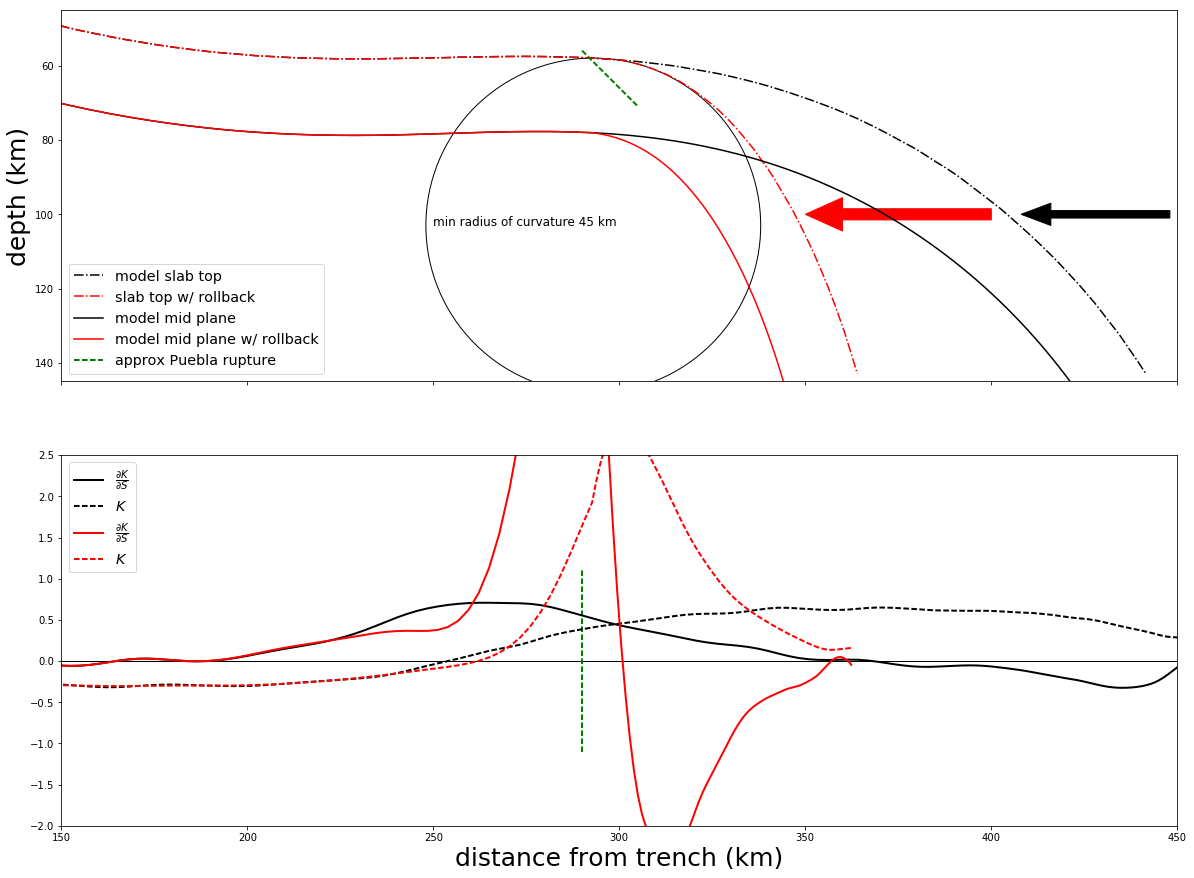

In [55]:
import matplotlib.patches as patches

#fig, ax = plt.subplots(figsize=(20,5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,15))
ax1.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1], 
         c = 'k', label = 'model slab top', ls = '-.')
ax1.plot(dimIntDataScaled[:,0] - trenchLoc, dimIntDataScaled[:,1],
         c = 'r', label = 'slab top w/ rollback', ls = '-.')
ax1.plot(dimData[:,0] - trenchLoc, dimData[:,1], c = 'k', label = 'model mid plane')
ax1.plot(dimDataScaled[:,0] - trenchLoc, dimDataScaled[:,1], c = 'r', label = 'model mid plane w/ rollback')


#ax.vlines(-0.1890954*2900., 0., 140)
ax1.set_ylim(160, 30)
ax1.set_xlim(150, 450)
ax1.set_aspect('equal')
#-0.1890954

ax1.add_patch(
    patches.Arrow(
        400,            # x
        100,            # y
        -50,            # dx
        0,            # dy
        width=15,      # optional - defaults to 1.0
        color = 'r'
    )
)


ax1.add_patch(
    patches.Arrow(
        448,            # x
        100,            # y
        -40,            # dx
        0,            # dy
        width=10,      # optional - defaults to 1.0
        color = 'k'
    )
)


ax1.plot([290,305], [56,71], lw = 2, c='g', ls = '--', label = 'approx Puebla rupture')


ax1.add_patch(patches.Circle((293,103), radius=45, fill=False))

#ax1.plot([290,308], [103, 62], lw = 3, c = 'k')
ax1.text(250, 103, 'min radius of curvature 45 km',  fontsize=12)

ax1.legend(fontsize = 'x-large', loc = 3)


ax1.set_ylabel('depth (km)', size = 25)
trenchLoc = -510.

ax2.plot(dimData[::1,0] - trenchLoc, -1.*(cx_F1*(1./2900e3**2))/2e-10, 
       c = 'k', lw = 2,  label = r'$\frac{\partial{K}}{\partial{S}}$ ')

ax2.plot(dimData[::1,0] - trenchLoc, -1.*(c_F*(1./2900e3))/10e-6, c = 'k',
        lw = 2,ls = '--', label = r'$K$')

ax2.plot(dimDataScaled[::1,0] - trenchLoc, -1.*(_cx_F1*(1./2900e3**2))/2e-10, 
       c = 'r', lw = 2,  label = r'$\frac{\partial{K}}{\partial{S}}$ ')

ax2.plot(dimDataScaled[::1,0] - trenchLoc, -1.*(_c_F*(1./2900e3))/10e-6, c = 'r',
        lw = 2,ls = '--', label = r'$K$')

ax2.legend(loc = 2, fontsize = 'x-large')
ax2.hlines(0, -200, 560, lw=1)
ax2.vlines(290, -1.1, 1.1, lw=2, colors='g', linestyles='--')

ax2.set_ylim(-2., 2.5)
#ax2.set_xlim(-200, 450)

ax2.set_xlabel('distance from trench (km)',  size = 25)



In [56]:
#fig.savefig('corrected_profile.png', dpi=300, bbox_inches='tight')

In [317]:
ax1.text?

In [213]:
#np.savetxt('slabTop.csv', dimIntData, delimiter=',')
#np.savetxt('slabTopCorrected.csv', dimIntDataScaled, delimiter=',')

In [214]:
#np.savetxt('midPlane.csv', dimData, delimiter=',')
#np.savetxt('midPlaneCorrected.csv', dimDataScaled, delimiter=',')

In [218]:
#midPlaneCurvCorrected = np.column_stack( ( dimDataScaled[:,0], -1.*(_c_F*(1./2900e3)) ))
#midPlaneCurvGradCorrected = np.column_stack( ( dimDataScaled[:,0], -1.*(_cx_F1*(1./2900e3**2)) ))

#np.savetxt('curvCorrected.csv', midPlaneCurvCorrected , delimiter=',')
#np.savetxt('curvGradCorrected.csv', midPlaneCurvGradCorrected , delimiter=',')

In [222]:
#test = np.loadtxt('curvCorrected.csv', delimiter=',')

## Slab top curvature

In [279]:
Wn2 = 0.03 #

B2, A2 = signal.butter(N, Wn2, output='ba')



fy = CubicSpline(dimIntData[:,0]/2900., dimIntData[:,1]/2900.)
y1_ = fy.derivative(1)(dimIntData[:,0]/2900.)
y2_ = fy.derivative(2)(dimIntData[:,0]/2900.)
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)

#c_F = gaussian_filter(c_, 5)
c_F = signal.filtfilt(B2,A2, c_)

dxMean = ds.min()*1

_cx_0 = np.gradient(c_, dxMean)
_cx_F= signal.filtfilt(B2,A2, _cx_0)
_cx_F1= signal.filtfilt(B2,A2, _cx_0)

fy = CubicSpline(dimIntDataScaled[:,0]/2900., dimIntDataScaled[:,1]/2900.)
y1_ = fy.derivative(1)(dimIntDataScaled[:,0]/2900.)
y2_ = fy.derivative(2)(dimIntDataScaled[:,0]/2900.)
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)

#c_F = gaussian_filter(c_, 5)
_c_F = signal.filtfilt(B2,A2, c_)

dxMean = ds.min()*1


__cx_0 = np.gradient(_c_F, dxMean)
__cx_F= signal.filtfilt(B2,A2, __cx_0)
__cx_F1= signal.filtfilt(B2,A2, __cx_0)

In [280]:
(1./np.abs((c_F*(1./2900e3)))).min(), (1./np.abs((_c_F*(1./2900e3)))).min()

(157352.60712676102, 44381.052716797087)

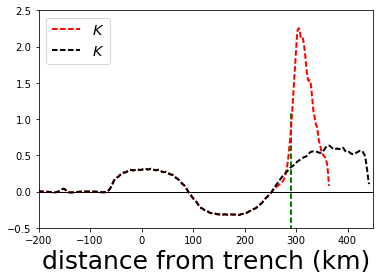

In [281]:
fig, ax = plt.subplots()

#ax.plot(dimIntDataScaled[::1,0] - trenchLoc, (__cx_F1*(1./2900e3**2))/2e-10, 
#       c = 'k', lw = 2,  label = r'$\frac{\partial{K}}{\partial{S}}$ ')

ax.plot(dimIntDataScaled[::1,0] - trenchLoc, (_c_F*(1./2900e3))/10e-6, c = 'r',
        lw = 2,ls = '--', label = r'$K$')

ax.plot(dimIntData[::1,0] - trenchLoc, (c_F*(1./2900e3))/10e-6, c = 'k',
        lw = 2,ls = '--', label = r'$K$')

ax.legend(loc = 2, fontsize = 'x-large')
ax.hlines(0, -200, 560, lw=1)
ax.vlines(290, -1.1, 1.1, lw=2, colors='g', linestyles='--')

ax.set_ylim(-0.5, 2.5)
ax.set_xlim(-200, 450)

ax.set_xlabel('distance from trench (km)',  size = 25)

## old

In [ ]:
#np.arange(8, 56,8)

times = [3.8, 7.7, 12.5, 17.3, 22.2, 30.1]

# Four axes, returned as a 2-d array
#f, axarr = plt.subplots(3, 2)
#f.tight_layout()
f = plt.figure(figsize = (7.25,6))
gs1 = gridspec.GridSpec(3, 2)
gs1.update(wspace=0.05, hspace=0.025)


count = 0
for i in np.arange(8, 56,8):
    tfile = tempFiles[i]
    tempField.load(tfile)
    tempdata = tempField.evaluate(coords[:, :])[:,0]
    #build array to collect the data
    temp = np.zeros(xv.shape) 
    temp[:] = np.flipud(tempdata.reshape((xv.shape)))*1400.0
    
    ax = plt.subplot(gs1[count])
    #plt.subplot(gs1[i])

    
    ax.contourf(temp, cmap='coolwarm', vmax = 1400, vmin = 0, 
          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1000], alpha = 0.5, 
               levels = [    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1420.])

    ax.contour(temp, colors='k', levels=[650., 1250.], 
                     extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1000], linewidths = 0.5 )

    ax.hlines(660, -1000, 1000,  alpha = 0.5 , linewidths = 1 )

    ax.set_xlim(-800, 800)
    ax.set_ylim(800, 0)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    #print(count)
    ax.text(-750, 770,'{} Ma'.format(times[count]), size = 10)
    count += 1




In [441]:
tp = np.linspace(0, 1, 100)
prefac = 1./53400000000.0
adTemp = 0.81482485604
ndDepth = 0.4

Eref = 27.756703
TSref = 0.21

alpha0 = 1400/1300.
alpha = (1 + 0.8*(alpha0 - 1.))
Enew = 25.774081*alpha
TSnew = 0.195

VRef = 43.386502840435966
VNew = 40.287466923*alpha

In [442]:
alpha

1.0615384615384615

In [443]:
alpha0

1.0769230769230769

In [444]:
etaRef = ((Eref + ndDepth*VRef) / (tp + (ndDepth*adTemp) + TSref))

etaNew = (( Enew + ndDepth*VNew) / (tp + (ndDepth*adTemp) + TSnew))

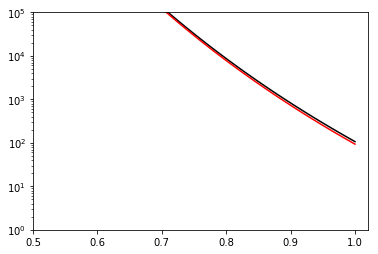

In [445]:
fig, ax = plt.subplots()
ax.plot(tp, prefac*np.exp(etaRef), c = 'k')
ax.plot(tp, prefac*np.exp(etaNew), c = 'r')

ax.set_ylim(1e0, 1e5)
ax.set_xlim(0.5, 1.02)
ax.set_yscale('log')

In [446]:
Enew, Eref

(27.36017829230769, 27.756703)

In [447]:
alpha

1.0615384615384615

SyntaxError: unexpected EOF while parsing (<ipython-input-410-20c4776e2e10>, line 1)